In [111]:
import os
import numpy as np
import random
import cv2
from shutil import copyfile
from alibi_detect.cd import ClassifierDrift
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_resnet.models import ResNet18
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from scipy.stats import binom_test
import pandas as pd

In [112]:
def load_image_paths_from_folders(base_dir, piece_folders):
    img_paths = []
    
    for folder in piece_folders:
        folder_path = os.path.join(base_dir, folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_paths.append(img_path)
    
    return img_paths

In [113]:
reference_dir = '/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split0'  # Path to reference images
drifted_dir = '/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split1'  # Path to drifted images
piece_folders = ['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']


In [114]:
source_paths = load_image_paths_from_folders(reference_dir, piece_folders)



In [115]:
target_paths = load_image_paths_from_folders(drifted_dir, piece_folders)

In [116]:
source_train, source_test = train_test_split(source_paths, test_size=0.5, random_state=42)
target_train, target_test = train_test_split(target_paths, test_size=0.5, random_state=42)



In [117]:
X_train_paths = source_train + target_train
X_test_paths = source_test + target_test

In [118]:
y_train = [0] * len(source_train) + [1] * len(target_train)
y_test = [0] * len(source_test) + [1] * len(target_test)

In [119]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [120]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [121]:
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data


In [122]:
# Define batch size
batch_size = 32

In [123]:
train_df = pd.DataFrame({'filename': X_train_paths, 'class': y_train.astype(str)})  # Convert labels to strings
val_df = pd.DataFrame({'filename': X_test_paths, 'class': y_test.astype(str)})

In [124]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="filename",
    y_col="class",
    target_size=(128, 128),  # Image size
    batch_size=batch_size,
    class_mode="binary",  # Binary classification (source vs. target)
    shuffle=True)

Found 66871 validated image filenames belonging to 2 classes.


In [125]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe= val_df,
    directory=None,
    x_col="filename",
    y_col="class",
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False)  # No need to shuffle validation data

Found 66873 validated image filenames belonging to 2 classes.


In [126]:
def build_resnet(input_shape, nb_classes=1):  # Set nb_classes to 1 for binary classification
    inputs = Input(shape=input_shape)  # Define the input layer with the correct input shape
    base_model = ResNet18(inputs, classes=1000)  # Load the base ResNet18 model (default 1000 output units)

    # Remove the last layer (fc1000) and add a new Dense layer with 1 unit and sigmoid activation
    x = base_model.layers[-2].output  # Get the output of the second to last layer
    output = Dense(nb_classes, activation='sigmoid')(x)  # Add a new Dense layer with sigmoid activation

    # Create the final model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
                  optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  metrics=['accuracy'])

    return model

In [127]:
input_shape = (128, 128, 3)
domain_classifier = build_resnet(input_shape)


In [128]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

In [129]:
model_checkpoint = ModelCheckpoint('resnet_domain_classifie_s5_s5drfit.h5', monitor='val_loss', save_best_only=True)


In [130]:
domain_classifier.fit(
    train_generator,
    steps_per_epoch=len(X_train_paths) // batch_size,  # Number of batches per epoch
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(X_test_paths) // batch_size,  # Number of batches for validation
    callbacks=[lr_reducer, early_stopper, model_checkpoint],
    verbose=1
)

Epoch 1/20


2024-10-01 12:05:58.288488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2089/2089 [==============================] - ETA: 0s - loss: 0.7098 - accuracy: 0.4989

2024-10-01 12:08:22.254417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2089/2089 [==============================] - 184s 87ms/step - loss: 0.7098 - accuracy: 0.4989 - val_loss: 0.7076 - val_accuracy: 0.4997 - lr: 0.0010
Epoch 2/20


/Users/ximenamoure/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2089/2089 [==============================] - 177s 85ms/step - loss: 0.7048 - accuracy: 0.5029 - val_loss: 0.6972 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 3/20
2089/2089 [==============================] - 177s 84ms/step - loss: 0.7038 - accuracy: 0.5032 - val_loss: 0.6957 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 4/20
2089/2089 [==============================] - 177s 85ms/step - loss: 0.7018 - accuracy: 0.4973 - val_loss: 0.7044 - val_accuracy: 0.4997 - lr: 0.0010
Epoch 5/20
2089/2089 [==============================] - 178s 85ms/step - loss: 0.7022 - accuracy: 0.4997 - val_loss: 0.7027 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 6/20
2089/2089 [==============================] - 178s 85ms/step - loss: 0.7010 - accuracy: 0.5018 - val_loss: 0.6946 - val_accuracy: 0.5002 - lr: 0.0010
Epoch 7/20
2089/2089 [==============================] - 177s 85ms/step - loss: 0.7009 - accuracy: 0.4990 - val_loss: 0.7003 - val_accuracy: 0.4996 - lr: 0.0010
Epoch 8/20
2089/2089 [=============================

In [131]:
probs = domain_classifier.predict(val_generator, steps=len(X_test_paths) // batch_size, verbose=1)


2024-10-01 13:06:58.435418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2089/2089 [==============================] - 39s 18ms/step


In [132]:
from scipy.stats import binom_test

# Step 1: Evaluate the classifier on the validation data
test_loss, test_accuracy = domain_classifier.evaluate(val_generator, steps=len(X_test_paths) // batch_size)

# Step 2: Perform the binomial test to check if accuracy is significantly different from 0.5
n_test_samples = len(X_test_paths)  # Total number of test samples
binom_result = binom_test(int(test_accuracy * n_test_samples), n=n_test_samples, p=0.5)

# Step 3: Output the test accuracy and p-value from the binomial test
print(f"Test Accuracy: {test_accuracy}")
print(f"Binomial Test p-value: {binom_result}")

2089/2089 [==============================] - 40s 19ms/step - loss: 0.6973 - accuracy: 0.4997
Test Accuracy: 0.4996858537197113
Binomial Test p-value: 0.8709798769268865


/var/folders/4p/y01p6zrx4351k0kmzl85g7r80000gn/T/ipykernel_62298/1167489073.py:8: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  binom_result = binom_test(int(test_accuracy * n_test_samples), n=n_test_samples, p=0.5)


In [133]:
print(f"Validation Accuracy: {test_accuracy}")

Validation Accuracy: 0.4996858537197113


In [134]:
print(f"Binomial Test p-value: {binom_result}")

Binomial Test p-value: 0.8709798769268865


In [135]:
# Check if the classifier's accuracy is significantly different from random guessing
if binom_result < 0.05:
    print("Drift detected (classifier's accuracy is significantly different from random guessing).")
else:
    print("No drift detected (classifier's accuracy is not significantly different from random guessing).")

No drift detected (classifier's accuracy is not significantly different from random guessing).


In [136]:
drifted_indices = np.argsort(-probs[:, 0])

In [137]:
len(drifted_indices)

66848

In [138]:
drifted_indices

array([57291, 56123, 11996, ..., 47025, 59797, 26871])

In [139]:
N = 10
top_drifted_indices = drifted_indices[:N]

# Retrieve the paths of the top N drifted images
top_drifted_paths = [X_test_paths[i] for i in top_drifted_indices]

# Output the indices and paths of the top predicted drifted images
print(f"Top {N} drifted images indices:", top_drifted_indices)
print(f"Paths of top {N} drifted images:", top_drifted_paths)

Top 10 drifted images indices: [57291 56123 11996 63821 26605 25641  6145  9268 52072 44728]
Paths of top 10 drifted images: ['/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split1/empty/chesslive_image_03-04-2022_101618_h5.png', '/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split1/empty/rendered_1462_e8.png', '/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split0/empty/rendered_3371_c2.png', '/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split1/empty/chesslive_image_03-04-2022_101538_h3.png', '/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split0/empty/rendered_2970_g6.png', '/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split0/empty/rendered_2103_e6.png', '/Users/ximenamoure/Chess-Piece-Classification-Dataset/images/processed/occupancy/split0/empty/rendered_2394_d7.png', '/Users/

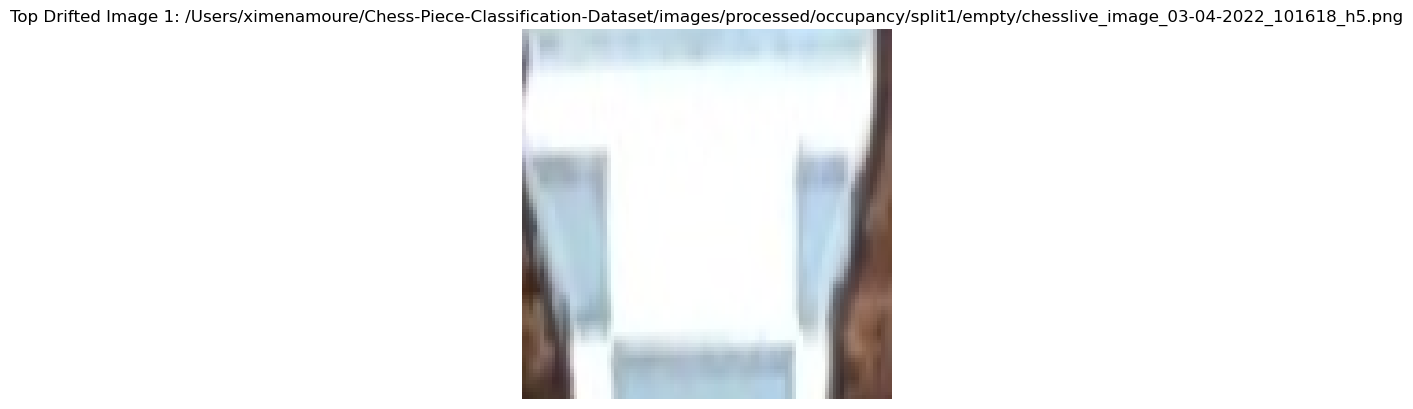

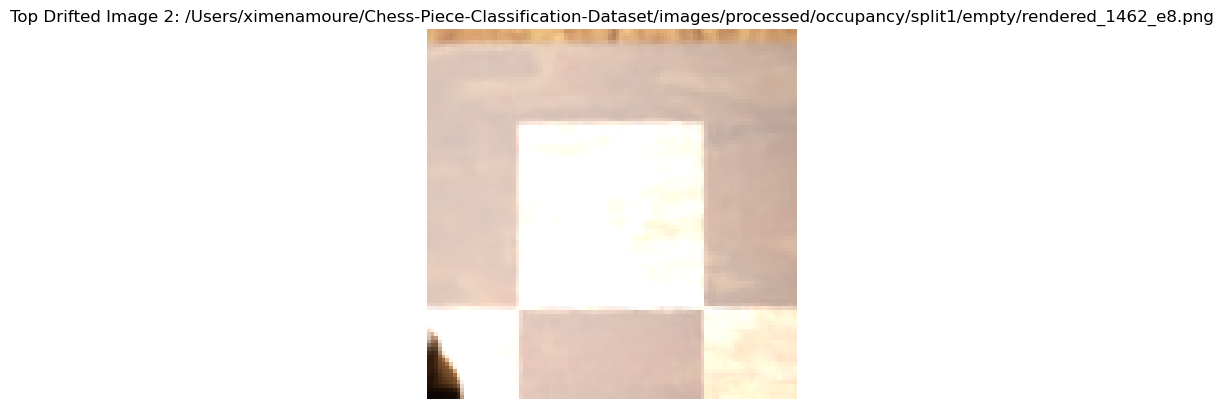

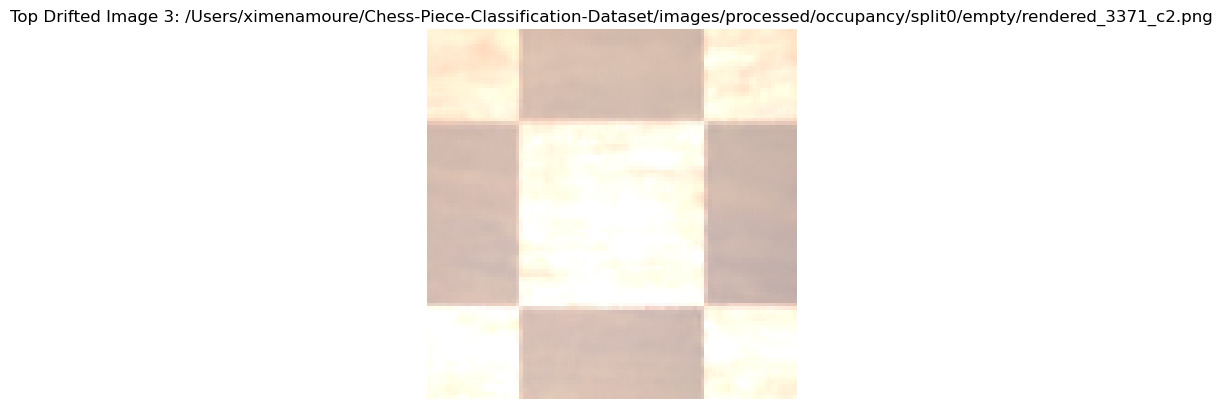

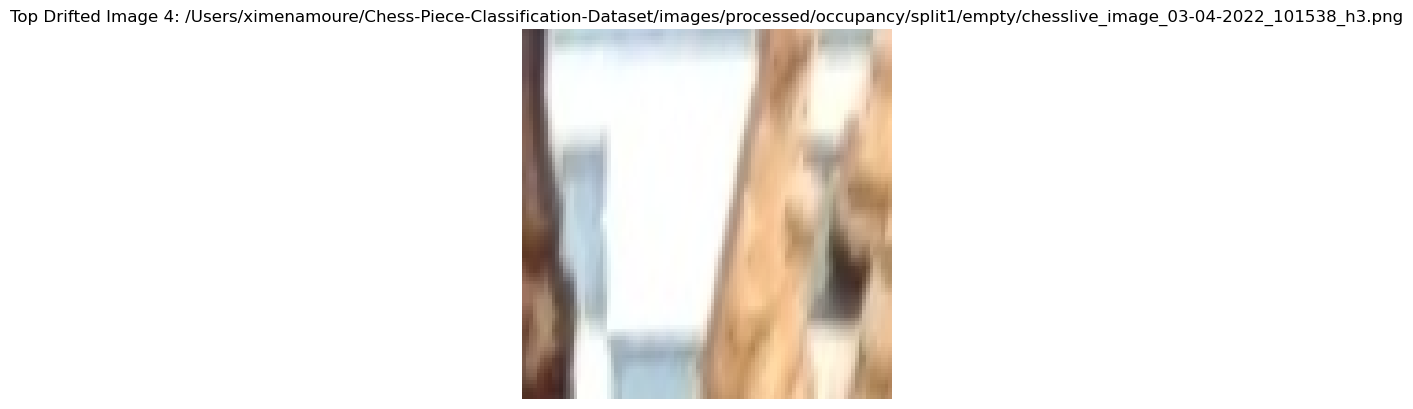

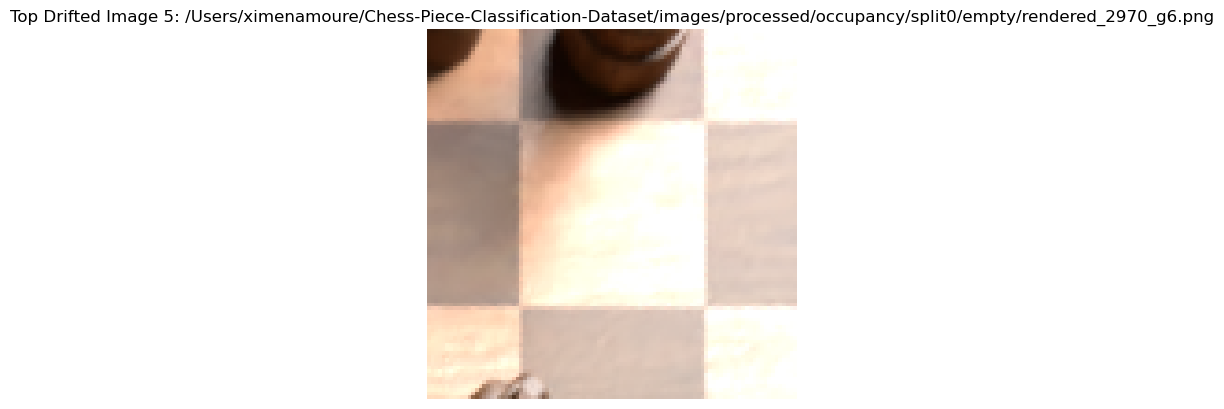

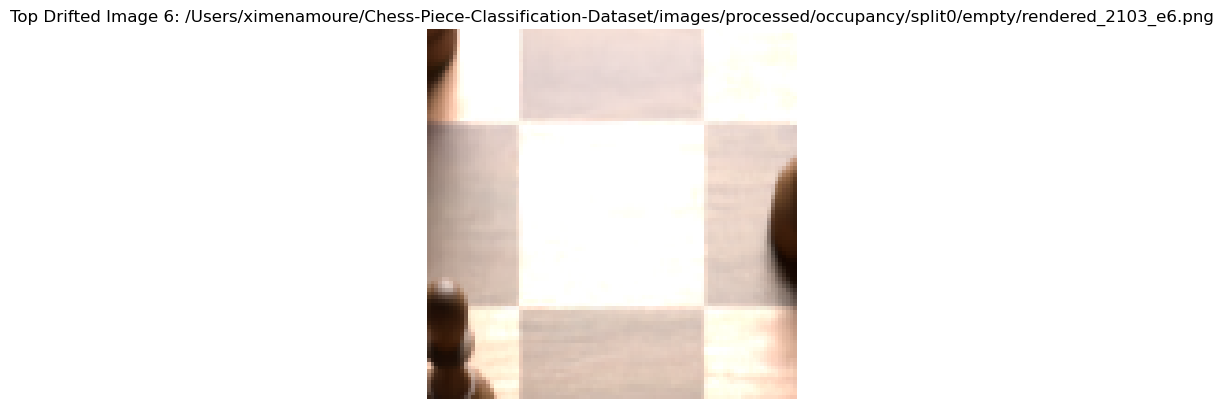

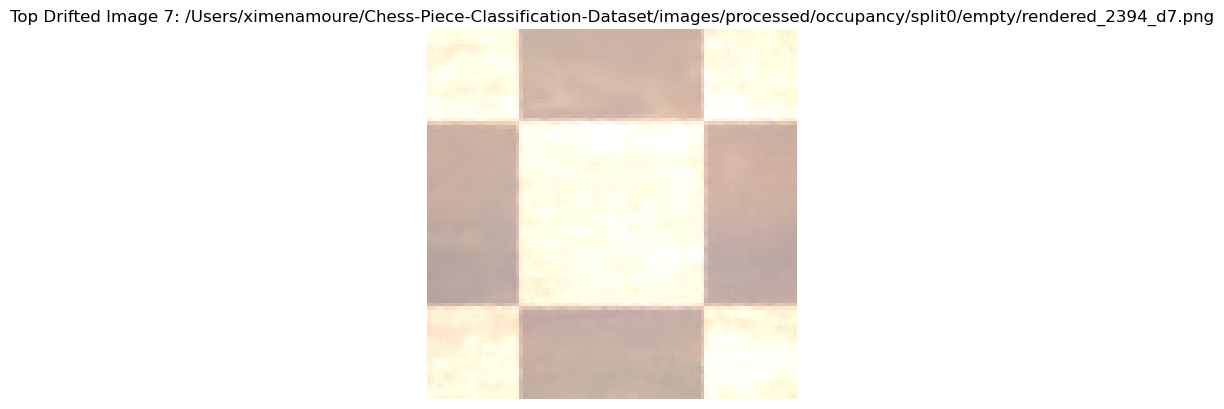

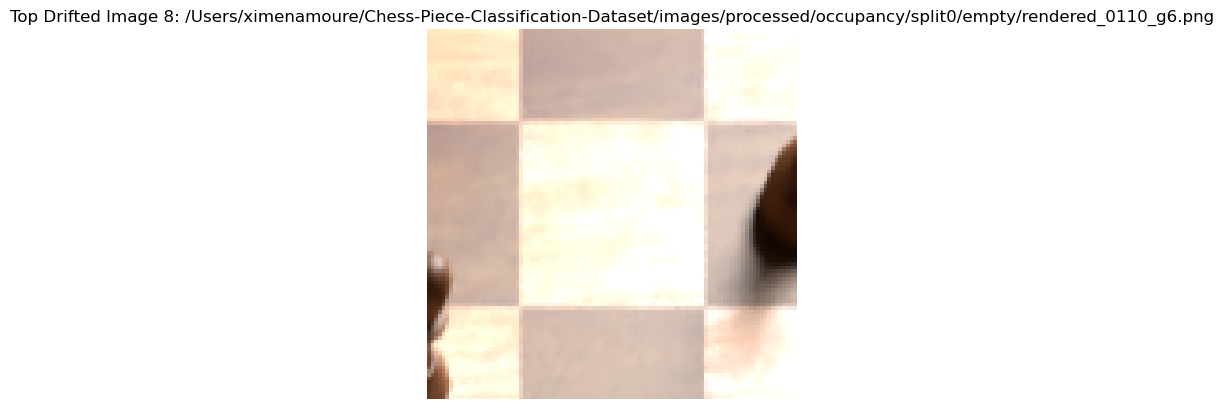

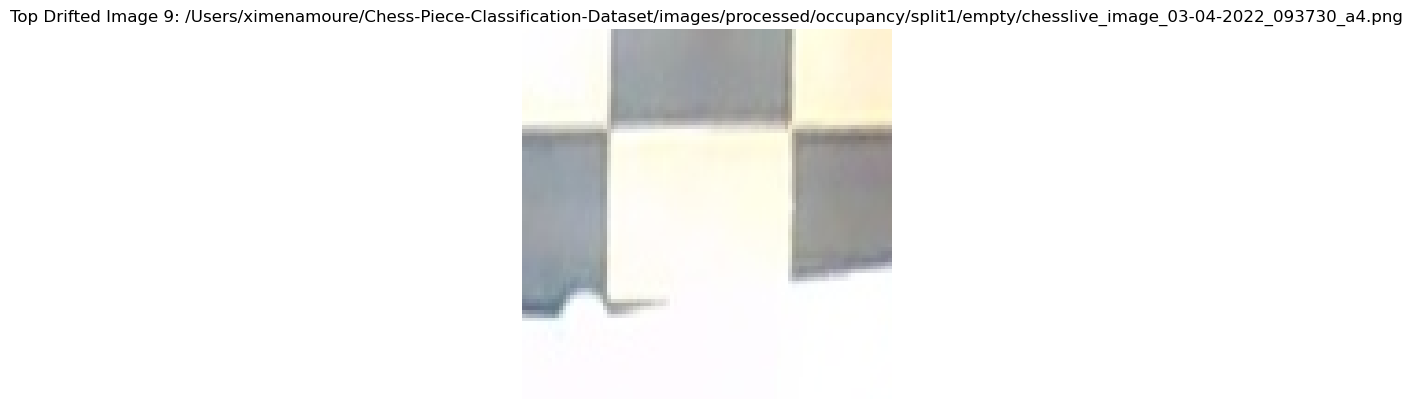

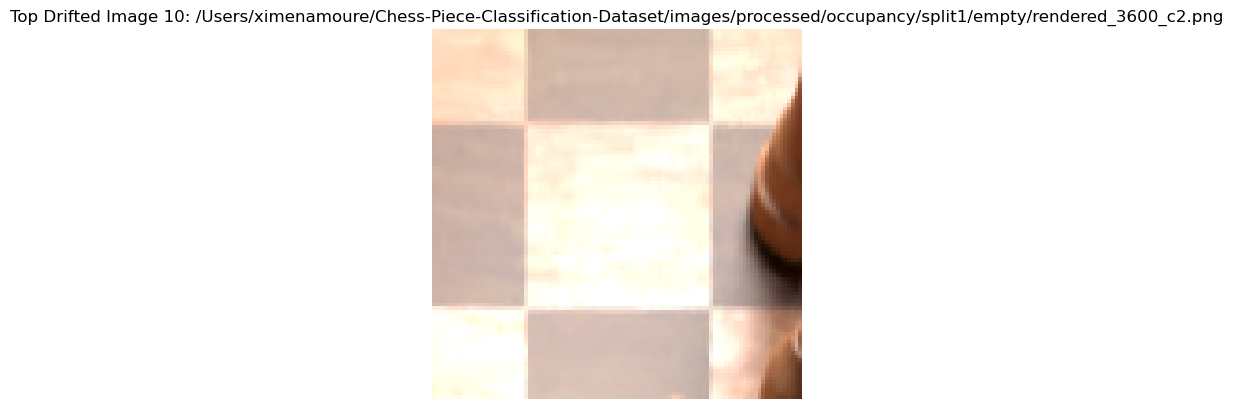

In [140]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Loop through the top N drifted images and display them
for i, img_path in enumerate(top_drifted_paths):
    img = mpimg.imread(img_path)  # Read the image from the file path
    plt.figure()  # Create a new figure for each image
    plt.imshow(img)  # Display the image
    plt.title(f"Top Drifted Image {i+1}: {img_path}")  # Add a title showing the image path
    plt.axis('off')  # Hide the axis
    plt.show()  # Show the image


In [147]:
# Define a threshold for classifying a sample as drifted
threshold = 0.6  # Adjust the threshold as needed

# Get the indices of samples where the predicted probability for class 1 (target) is above the threshold
drifted_indices_treshold = np.where(probs[:, 0] > threshold)[0]  # Only keep indices above the threshold

# Sort the drifted indices by their predicted probability in descending order
sorted_drifted_indices = drifted_indices_treshold[np.argsort(-probs[drifted_indices_treshold, 0])]

# Get the paths of the top drifted images above the threshold
top_drifted_paths_t = [X_test_paths[i] for i in sorted_drifted_indices]



In [148]:
len(top_drifted_paths_t)

1235

In [ ]:
# Output the paths of the top drifted images above the threshold
print(f"Paths of drifted images above the threshold ({threshold}):", top_drifted_paths_t)

In [83]:
comparison_folder = '/Users/ximenamoure/Desktop/drift_last/drifted/images'

In [84]:


# List of subfolders (assuming the structure is similar to your dataset splits)
piece_folders = ['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']

# Function to load image paths from the folder
def load_image_paths_from_folders(base_dir, piece_folders):
    img_paths = []
    
    for folder in piece_folders:
        folder_path = os.path.join(base_dir, folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_paths.append(img_path)
    
    return img_paths

In [85]:
comparison_paths = load_image_paths_from_folders(comparison_folder, piece_folders)

In [98]:
def extract_piece_and_filename(path):
    # Split the path to get the directory structure and filename
    parts = path.split(os.sep)  # Split the path by the separator
    piece_type = parts[-2]  # The second-to-last part should be the piece type (bb, wr, etc.)
    filename = parts[-1]  # The last part is the filename
    return piece_type, filename

In [ ]:
example_path = "/Desktop/drift_last/drifted/images/bb/WC2023_WC-Round8-2023-06-21_11-21-55_b4.png"
piece_type, filename = extract_piece_and_filename(example_path)
print(piece_type, filename)

In [104]:
top_drifted_info = [extract_piece_and_filename(path) for path in top_drifted_paths_t]

# Extract piece type and filenames for comparison paths
comparison_info = [extract_piece_and_filename(path) for path in comparison_paths]

# Find how many of the top drifted images match based on piece type and filename
matched_paths = [top_drifted_paths_t[i] for i, drifted_info in enumerate(top_drifted_info) if drifted_info in comparison_info]



In [ ]:
len(matched_paths)

In [ ]:
len(comparison_info)

In [ ]:
top_drifted_info

In [ ]:
comparison_info

In [ ]:
# Output the number of matched paths and the matched image paths
print(f"Number of matched drifted images: {len(matched_paths)}")
print("Matched image paths:", matched_paths)